In [1]:
import lib.db_connector
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

#Set to true if database connection is not available
local = True

if not local:
    db = lib.db_connector.DbConnector(db_name = 'speakql_study', verbose = False)

In [2]:
if not local:
    res_df = db.do_single_select_query_into_dataframe("""
    select * from survey_answers
    """)
    res_df.to_excel('./data/df/survey-responses-res-df.xlsx')
else:
    res_df = pd.read_excel('./data/df/survey-responses-res-df.xlsx')
    
res_df



,Unnamed: 0,idparticipant,username,sql_experience,sql_skill_level,used_synonyms,synonyms_feature_useful,select_synonym_compare,from_synonym_compare,join_synonym_compare,...,unbundle_not_use_comment,used_mod_order,mod_order_feature_useful,mod_order_two_mod_feature_compare,mod_order_three_mod_feature_compare,suggestions_mod_order,mod_order_not_use_rsn,mod_order_not_use_comment,general_comments_positive,general_comments_negative
0,0,1,participant1,New professional,4,Yes,Yes,About the same,Somewhat easier,About the same,...,NaN,No,NaN,NaN,NaN,NaN,Already comfortable with SQL syntax,NaN,The count of/ the average of is much easier th...,When there are more than two tables to join th...
1,1,2,participant2,Graduate student,4,Yes,Yes,Much easier,Much easier,Somewhat more difficult,...,NaN,No,NaN,NaN,NaN,NaN,Already comfortable with SQL syntax;Couldn't r...,I didn't realize this existed. One of my previ...,It is easier to create queries if construction...,Yes using the JOIN WITH and mentioning the QUO...
2,2,3,participant3,Graduate student,5,Yes,Yes,Much easier,Much easier,Much easier,...,NaN,Yes,Yes,About the same,About the same,NaN,NaN,NaN,Much cooler way of using SQL,At times speaking the exact words like comma w...
3,3,4,participant4,Graduate student,4,Yes,Yes,Much easier,Much easier,Much easier,...,NaN,No,NaN,NaN,NaN,NaN,Already comfortable with SQL syntax,NaN,NaN,NaN
4,4,5,participant5,Graduate student,4,Yes,Yes,Somewhat easier,Somewhat easier,Much easier,...,NaN,Yes,Yes,Much easier,Much easier,NaN,NaN,NaN,NaN,NaN
5,5,7,participant7,Graduate student,2,Yes,Yes,Somewhat easier,Much easier,Somewhat easier,...,NaN,Yes,Yes,About the same,Somewhat easier,NaN,NaN,NaN,NaN,NaN
6,6,8,participant8,Graduate student,3,Yes,Yes,About the same,About the same,Somewhat easier,...,NaN,Yes,Yes,Much easier,Much easier,Maybe move having clauses into where clauses e...,NaN,NaN,No particular things but I guess just in gener...,I tend to get used to language syntax especial...
7,7,6,participant6,Graduate student,4,Yes,Yes,About the same,Somewhat easier,Much easier,...,NaN,Yes,Yes,Somewhat easier,Much easier,Automatically is great option but felt less in...,NaN,NaN,It's certainly great step towards being intuit...,Not sure if things like quotes distinct other...
8,8,10,Participant10,Graduate student,4,Yes,Yes,Somewhat easier,About the same,Somewhat easier,...,NaN,Yes,Yes,Much easier,Much easier,NaN,NaN,NaN,SpeakQL definitely makes dictation of queries ...,Found the usage of quote unnecessary it would ...
9,9,12,participant12,Senior professional,5,No,NaN,NaN,NaN,NaN,...,NaN,Yes,Yes,About the same,About the same,NaN,NaN,NaN,NaN,NaN


In [3]:
compare_columns = [column for column in res_df.columns if '_compare' in column]

for col in compare_columns:
    res_df[col] = res_df.apply(lambda row: row[col].strip() if type(row[col]) == str else '', axis = 1)
    
compare_columns

['select_synonym_compare',
 'from_synonym_compare',
 'join_synonym_compare',
 'comma_synonym_compare',
 'ordering_simple_feature_compare',
 'ordering_complex_feature_compare',
 'natural_func_no_paren_feature_compare',
 'natural_func_theof_feature_compare',
 'unbundle_two_tbl_feature_compare',
 'unbundle_three_tbl_feature_compare',
 'unbundle_aggr_feature_compare',
 'mod_order_two_mod_feature_compare',
 'mod_order_three_mod_feature_compare']

## Feature usage

**Count of features used**

['used_synonyms', 'used_ordering', 'used_natural_func', 'used_unbundle', 'used_mod_order']


<AxesSubplot:xlabel='feature'>

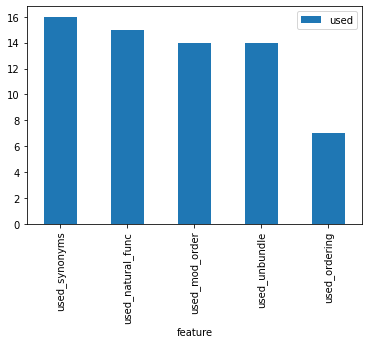

In [4]:
used_columns = []
for column in res_df.columns:
    if 'used_' in column:
        used_columns.append(column)
print(used_columns)
res_df_melt = res_df[used_columns].melt()
res_df_melt

usage_counts = res_df_melt.where(res_df_melt.value == 'Yes').dropna(how = 'all').groupby(['variable']).count().reset_index()
usage_counts.columns = ['feature', 'used']
usage_counts.sort_values(by='used', ascending=False).plot.bar(x = 'feature', y='used')

### Participant perceptions of usefulness

In [5]:
res_df.columns

Index(['Unnamed: 0', 'idparticipant', 'username', 'sql_experience',
       'sql_skill_level', 'used_synonyms', 'synonyms_feature_useful',
       'select_synonym_compare', 'from_synonym_compare',
       'join_synonym_compare', 'comma_synonym_compare', 'suggestions_synonym',
       'synonyn_not_use_rsn', 'synonym_not_use_comment', 'used_ordering',
       'ordering_feature_useful', 'ordering_simple_feature_compare',
       'ordering_complex_feature_compare', 'suggestions_ordering',
       'ordering_not_use_rsn', 'ordering_not_use_comment', 'used_natural_func',
       'natural_func_feature_useful', 'natural_func_no_paren_feature_compare',
       'natural_func_theof_feature_compare', 'suggestions_natural_func',
       'natural_func_not_use_rsn', 'natural_func_not_use_comment',
       'used_unbundle', 'unbundle_feature_useful',
       'unbundle_two_tbl_feature_compare',
       'unbundle_three_tbl_feature_compare', 'unbundle_aggr_feature_compare',
       'suggestions_unbundle', 'unbundle_not_

In [6]:
compares = pd.melt(
    res_df,
    id_vars = ['username'],
    value_vars = compare_columns
)
compare_dist = compares.groupby(['variable', 'value']).count()

compare_dist = compare_dist.reset_index()
compare_dist.value = compare_dist.apply(lambda row: "Did not use" if row.value == "" else row.value, axis = 1)

In [7]:
val_map = {
    "Much more difficult": -2,
    "Somewhat more difficult" : -1,
    "About the same": 0,
    "Somewhat easier": 1,
    "Much easier": 2,
    "": -99,
    "Did not use": -99
}

compares['value_num'] = compares.apply(lambda row: val_map[row.value.strip()], axis = 1)
compares['value'] = compares.apply(lambda row: row.value if row.value != "" else "Did not use", axis = 1)

compares

,username,variable,value,value_num
0,participant1,select_synonym_compare,About the same,0
1,participant2,select_synonym_compare,Much easier,2
2,participant3,select_synonym_compare,Much easier,2
3,participant4,select_synonym_compare,Much easier,2
4,participant5,select_synonym_compare,Somewhat easier,1
...,...,...,...,...
216,participant14,mod_order_three_mod_feature_compare,Much easier,2
217,Participant 16,mod_order_three_mod_feature_compare,Somewhat easier,1
218,participant17,mod_order_three_mod_feature_compare,Somewhat easier,1
219,participant19,mod_order_three_mod_feature_compare,Somewhat easier,1


### Feature Affinity:

#### Ordered by popularity

In [8]:
compares.where(
    compares.value_num > -5
).dropna(how='all')[['variable', 'value_num']].groupby(
    "variable"
).sum().sort_values("value_num")

,value_num
variable,
ordering_simple_feature_compare,6.0
ordering_complex_feature_compare,7.0
mod_order_two_mod_feature_compare,14.0
mod_order_three_mod_feature_compare,16.0
join_synonym_compare,17.0
unbundle_two_tbl_feature_compare,17.0
from_synonym_compare,18.0
select_synonym_compare,18.0
unbundle_aggr_feature_compare,18.0


#### Features with negative responses

In [9]:
negatives = compares.where(compares.value_num < 0)
negatives = negatives.where(negatives.value_num > -5)
negatives = negatives.dropna(how='all')
negatives

,username,variable,value,value_num
35,participant2,join_synonym_compare,Somewhat more difficult,-1.0
44,participant11,join_synonym_compare,Somewhat more difficult,-1.0
65,participant17,comma_synonym_compare,Somewhat more difficult,-1.0
153,participant1,unbundle_three_tbl_feature_compare,Somewhat more difficult,-1.0
180,participant11,unbundle_aggr_feature_compare,Somewhat more difficult,-1.0


In [10]:
res_df.columns

Index(['Unnamed: 0', 'idparticipant', 'username', 'sql_experience',
       'sql_skill_level', 'used_synonyms', 'synonyms_feature_useful',
       'select_synonym_compare', 'from_synonym_compare',
       'join_synonym_compare', 'comma_synonym_compare', 'suggestions_synonym',
       'synonyn_not_use_rsn', 'synonym_not_use_comment', 'used_ordering',
       'ordering_feature_useful', 'ordering_simple_feature_compare',
       'ordering_complex_feature_compare', 'suggestions_ordering',
       'ordering_not_use_rsn', 'ordering_not_use_comment', 'used_natural_func',
       'natural_func_feature_useful', 'natural_func_no_paren_feature_compare',
       'natural_func_theof_feature_compare', 'suggestions_natural_func',
       'natural_func_not_use_rsn', 'natural_func_not_use_comment',
       'used_unbundle', 'unbundle_feature_useful',
       'unbundle_two_tbl_feature_compare',
       'unbundle_three_tbl_feature_compare', 'unbundle_aggr_feature_compare',
       'suggestions_unbundle', 'unbundle_not_

In [11]:
negatives_comments = res_df.where(res_df.username.isin(negatives.username)).dropna(how='all')
suggestions_columns = []
for col in res_df.columns:
    if "suggestions" in col:
        suggestions_columns.append(col)
negatives_suggestions = negatives_comments[['username'] + suggestions_columns]
negatives_suggestions

,username,suggestions_synonym,suggestions_ordering,suggestions_natural_func,suggestions_unbundle,suggestions_mod_order
0,participant1,NaN,NaN,NaN,NaN,NaN
1,participant2,JOIN TABLE1 WITH TABLE2 felt hard for me becau...,I am curious if we can reorder the groupby hav...,None I felt this was really good.,Though complex query bundling was easier it ta...,NaN
10,participant11,The join synonyms can use some structural chan...,NaN,NaN,NaN,NaN
14,participant17,NaN,NaN,NaN,NaN,NaN


### Feature usage histograms

In [12]:
compares

,username,variable,value,value_num
0,participant1,select_synonym_compare,About the same,0
1,participant2,select_synonym_compare,Much easier,2
2,participant3,select_synonym_compare,Much easier,2
3,participant4,select_synonym_compare,Much easier,2
4,participant5,select_synonym_compare,Somewhat easier,1
...,...,...,...,...
216,participant14,mod_order_three_mod_feature_compare,Much easier,2
217,Participant 16,mod_order_three_mod_feature_compare,Somewhat easier,1
218,participant17,mod_order_three_mod_feature_compare,Somewhat easier,1
219,participant19,mod_order_three_mod_feature_compare,Somewhat easier,1


### Feature feedback - Synonyms

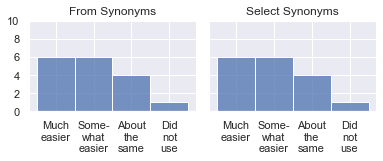

In [13]:
import matplotlib.pyplot as plt
sns.set_theme(rc={
    "figure.figsize": [16, 16],
    'legend.title_fontsize': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 12
})
compares['SQL Comparison'] = compares.apply(lambda row: row.value.replace(" ", "\n"), axis=1)
compares['SQL Comparison'] = compares.apply(lambda row: row["SQL Comparison"].replace("Somewhat", "Some-\nwhat"), axis=1)
compares['Feature'] = compares.apply(lambda row:
                                        {
                                            'comma_synonym_compare': "Comma Synonym",
                                            'from_synonym_compare': "From Synonyms",
                                            'select_synonym_compare': "Select Synonyms",
                                            'join_synonym_compare': "Join Synonyms",
                                            'ordering_simple_feature_compare': "Simple clause ordering",
                                            'ordering_complex_feature_compare': "Complex clause ordering",
                                            'mod_order_two_mod_feature_compare': "Modifier ordering - two mods",
                                            'mod_order_three_mod_feature_compare' : "Modifier ordering -three mods",
                                            'natural_func_theof_feature_compare': "Natural functions - the of keywords",
                                            'natural_func_no_paren_feature_compare': "Natural functions - no parens",
                                            'unbundle_two_tbl_feature_compare': "Unbundling - two tables",
                                            'unbundle_three_tbl_feature_compare': "Unbundling - three or more tables",
                                            'unbundle_aggr_feature_compare': "Unbundling - group by automatically"                                            
                                        }[row.variable],
                                     axis=1
                                    )
grid = sns.FacetGrid(
    compares.query('variable in ["select_synonym_compare", "from_synonym_compare"]').sort_values(
        by='value_num', ascending = False
    ), 
    col='Feature', 
    col_wrap = 4,
    height=2.6
)
grid.map(sns.histplot, 'SQL Comparison', stat='count', discrete=True)
grid.set_xticklabels(rotation = 0)
grid.set(ylim=(0,10), xlabel=None, yticks=[0, 2, 4, 6, 8, 10])
grid.set_titles("{col_name}")
grid.savefig("synonym-feedback-1.pdf")

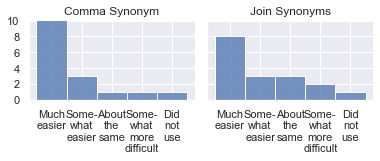

In [14]:
grid = sns.FacetGrid(
    compares.query('variable in ["comma_synonym_compare", "join_synonym_compare"]').sort_values(
        by='value_num', ascending = False
    ), 
    col='Feature', 
    col_wrap = 4,
    height=2.6
)
grid.map(sns.histplot, 'SQL Comparison', stat='count', discrete=True)
grid.set_xticklabels(rotation = 0)
grid.set(ylim=(0,10), xlabel=None, yticks=[0, 2, 4, 6, 8, 10])
grid.set_titles("{col_name}")

grid.savefig("synonym-feedback-2.pdf")

### Feature feedback - Ordering

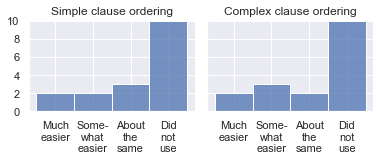

In [15]:
sns.set_theme(rc={
    "figure.figsize": [16, 16],
    'legend.title_fontsize': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 12
})

grid = sns.FacetGrid(
    compares.query(
        'variable in ["ordering_simple_feature_compare", "ordering_complex_feature_compare"]'
        ).sort_values(
        by='value_num', ascending = False
    ), col='Feature', col_wrap = 4,
    height=2.6
)
grid.map(sns.histplot, 'SQL Comparison', stat='count', discrete=True)
grid.set_xticklabels(rotation = 0)
grid.set(ylim=(0,10), xlabel=None, yticks=[0, 2, 4, 6, 8, 10])
grid.set_titles("{col_name}")
grid.savefig("ordering-feedback-1.pdf")

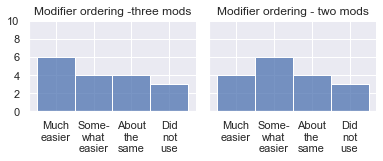

In [16]:
grid = sns.FacetGrid(
    compares.query(
        'variable in ["mod_order_two_mod_feature_compare","mod_order_three_mod_feature_compare"]'
        ).sort_values(
        by='value_num', ascending = False
    ), 
    col='Feature', 
    col_wrap = 4,
    height=2.6
)
grid.map(sns.histplot, 'SQL Comparison', stat='count', discrete=True)
grid.set_xticklabels(rotation = 0)
grid.set(ylim=(0,10), xlabel=None, yticks=[0, 2, 4, 6, 8, 10])
grid.set_titles("{col_name}")
grid.savefig("ordering-feedback-2.pdf")

### Feature feedback - Natural Functions

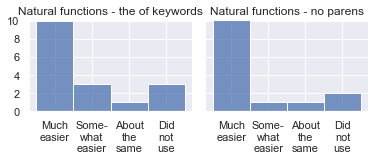

In [17]:
sns.set_theme(rc={
    "figure.figsize": [16, 16],
    'legend.title_fontsize': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 12
})
grid = sns.FacetGrid(
    compares.query(
        'variable in ["natural_func_theof_feature_compare", "natural_func_no_paren_feature_compare"]'
        ).sort_values(
        by=['variable', 'value_num'], ascending = False
    ), col='Feature', col_wrap = 4,
    height=2.6
)
grid.map(sns.histplot, 'SQL Comparison', stat='count', discrete=True)
grid.set_xticklabels(rotation = 0)
grid.set(ylim=(0,10), xlabel=None, yticks=[0, 2, 4, 6, 8, 10])
grid.set_titles("{col_name}")
grid.savefig("function-feedback.pdf")

### Feature feedback - Unbundling

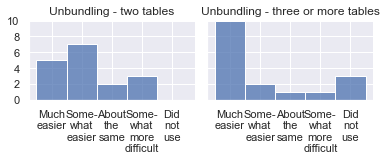

In [18]:
sns.set_theme(rc={
    "figure.figsize": [16, 16],
    'legend.title_fontsize': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 12
})
grid = sns.FacetGrid(
    compares.query('variable in ["unbundle_two_tbl_feature_compare", "unbundle_three_tbl_feature_compare"]').sort_values(
        by='value_num', ascending = False
    ), col='Feature', col_wrap = 4,
    height=2.6
)
grid.map(sns.histplot, 'SQL Comparison', stat='count', discrete=True)
grid.set_xticklabels(rotation = 0)
grid.set(ylim=(0,10), xlabel=None, yticks=[0, 2, 4, 6, 8, 10])
grid.set_titles("{col_name}")
grid.savefig("unbundling-feedback.pdf")

### Reasons for no use

In [19]:
not_use_columns = [colname for colname in res_df.columns if "_not_use_rsn" in colname]
not_use_df = res_df[['idparticipant'] + not_use_columns]
not_use_df

,idparticipant,synonyn_not_use_rsn,ordering_not_use_rsn,natural_func_not_use_rsn,unbundle_not_use_rsn,mod_order_not_use_rsn
0,1,NaN,NaN,NaN,NaN,Already comfortable with SQL syntax
1,2,NaN,NaN,NaN,NaN,Already comfortable with SQL syntax;Couldn't r...
2,3,NaN,NaN,NaN,NaN,NaN
3,4,NaN,Already comfortable with SQL syntax,NaN,NaN,Already comfortable with SQL syntax
4,5,NaN,Already comfortable with SQL syntax,Couldn't remember correct usage criteria,NaN,NaN
5,7,NaN,NaN,NaN,NaN,NaN
6,8,NaN,Already comfortable with SQL syntax,NaN,NaN,NaN
7,6,NaN,Already comfortable with SQL syntax,NaN,NaN,NaN
8,10,NaN,NaN,NaN,Already comfortable with SQL syntax;Couldn't r...,NaN
9,12,Already comfortable with SQL syntax,NaN,NaN,NaN,NaN


In [20]:
no_use_df_melt = not_use_df.melt(value_vars=not_use_columns)
no_use_df_melt = no_use_df_melt.where(no_use_df_melt.value != "").dropna()
order={
    'ordering_not_use_rsn' : 1,
    'unbundle_not_use_rsn' : 2,
    'mod_order_not_use_rsn' : 3,
    'natural_func_not_use_rsn' : 4,
    'synonyn_not_use_rsn' : 5
}
no_use_df_melt['order'] = no_use_df_melt.apply(
    lambda row: order[row.variable], axis = 1
)
no_use_df_melt = no_use_df_melt.sort_values(by='order')
no_use_df_melt


,variable,value,order
32,ordering_not_use_rsn,"Already comfortable with SQL syntax, Not useful",1
20,ordering_not_use_rsn,Already comfortable with SQL syntax,1
21,ordering_not_use_rsn,Already comfortable with SQL syntax,1
23,ordering_not_use_rsn,Already comfortable with SQL syntax,1
24,ordering_not_use_rsn,Already comfortable with SQL syntax,1
27,ordering_not_use_rsn,Too complicated;Already comfortable with SQL s...,1
28,ordering_not_use_rsn,Already comfortable with SQL syntax,1
30,ordering_not_use_rsn,Already comfortable with SQL syntax,1
31,ordering_not_use_rsn,Already comfortable with SQL syntax,1
33,ordering_not_use_rsn,Already comfortable with SQL syntax,1


In [21]:
variable = []
value = []
no_use_df_melt.columns
for row in no_use_df_melt.itertuples():
    if ";" not in row.value and "," not in row.value:
        value.append(row.value)
        variable.append(row.variable)
    if ";" in row.value and "," not in row.value:
        responses = row.value.split(";")
        for i in range(0, len(responses)):
            value.append(responses[i].strip())
            variable.append(row.variable)
    if "," in row.value and ";" not in row.value:
        responses = row.value.split(",")
        for i in range (0, len(responses)):
            value.append(responses[i].strip())
            variable.append(row.variable)
            
print(len(variable), len(value))

abbr_reasons = {
    "Already comfortable with SQL syntax" : "SQL Familiarity",
    "Not useful" : "Not Useful",
    "Too complicated" : "Complicated",
    "Couldn't remember correct ordering options" : "Forgot Syntax",
    "Couldn't remember correct usage criteria" : "Forgot Syntax",
    "Needed more practice to get comfortable with it" : "Need Practice"
}

        
not_used_parsed = pd.DataFrame({'variable': variable, 'value': value})
not_used_parsed['Reason'] = not_used_parsed.apply(
    lambda row: abbr_reasons[row.value], axis = 1
)
not_used_parsed

27 27


,variable,value,Reason
0,ordering_not_use_rsn,Already comfortable with SQL syntax,SQL Familiarity
1,ordering_not_use_rsn,Not useful,Not Useful
2,ordering_not_use_rsn,Already comfortable with SQL syntax,SQL Familiarity
3,ordering_not_use_rsn,Already comfortable with SQL syntax,SQL Familiarity
4,ordering_not_use_rsn,Already comfortable with SQL syntax,SQL Familiarity
5,ordering_not_use_rsn,Already comfortable with SQL syntax,SQL Familiarity
6,ordering_not_use_rsn,Too complicated,Complicated
7,ordering_not_use_rsn,Already comfortable with SQL syntax,SQL Familiarity
8,ordering_not_use_rsn,Couldn't remember correct ordering options,Forgot Syntax
9,ordering_not_use_rsn,Already comfortable with SQL syntax,SQL Familiarity


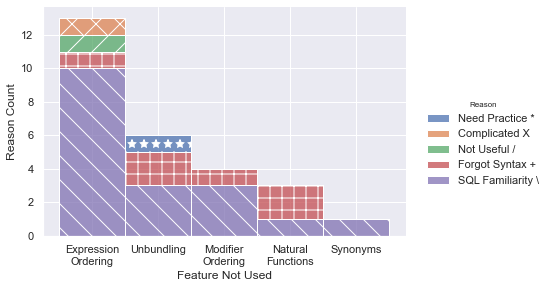

In [22]:
hatches = ['\\', '+', '/', 'x', '*']

temp_df = not_used_parsed.copy()

not_used_parsed.to_excel("features-not-used-barplot.xlsx")

temp_df['Reason'] = temp_df.apply(
    lambda row: {
        'Need Practice': 'Need Practice *',
        'Complicated': 'Complicated X',
        'Not Useful': 'Not Useful /',
        'Forgot Syntax': 'Forgot Syntax +',
        'SQL Familiarity': 'SQL Familiarity \\'
    }[row.Reason],
    axis=1
)

g = sns.displot(
    temp_df.rename(columns={'variable': 'Feature', 'value': 'Reason not Used'}), 
    x='Feature', 
    stat='count', 
    hue='Reason',
    hue_order = [
        'Need Practice *',
        'Complicated X',
        'Not Useful /',
        "Forgot Syntax +",
        'SQL Familiarity \\'
    ],
    multiple='stack',
    height=4,
    aspect=1.5,
)
g.set_xticklabels(
    ['Expression\nOrdering', 'Unbundling', 'Modifier\nOrdering', 'Natural\nFunctions', 'Synonyms'], 
    rotation = 0
)
g.set_axis_labels("Feature Not Used", "Reason Count", fontsize='medium')

for ax in g.fig.axes:
    for i, bar in enumerate(ax.patches):
        bar.set_hatch(hatches[int(i / 5)])
        
g.savefig('./feature_unused_reasons.pdf', dpi=300)


## Coding Analysis

### Initial Coding

In [23]:
#Load tags and parse into list
f = open('./data/coding.md')
coding_text = f.read()
f.close()
istag = False
isparticipant = False
tags = []
tag_participants = []
tag = ""
participant = ""
for char in coding_text:
    if char == "#" and not istag and char != " ":
        istag = True
        tag += char
    elif istag and (char == " " or char == "\n"):
        istag = False
        tags.append(tag)
        tag_participants.append(participant)
        tag = ""
    elif istag and char == "#":
        istag = False
        participant = ""
        isparticipant = True
        tag = ""
    elif istag:
        tag += char
    elif isparticipant and char != '\n':
        participant += char
    elif isparticipant and char == '\n':
        isparticipant = False
       

In [24]:
tag_df = pd.DataFrame({'participant' : tag_participants, 'tag' : tags})
tag_df.to_excel('tag_df.xlsx')

In [25]:
#Count tags
tag_counts = {}
for tag in tags:
    if "-participant" not in tag:
        tag = tag.replace("#userstudy-", "")
        if tag not in tag_counts:
            tag_counts[tag] = 1
        else:
            tag_counts[tag] += 1
tag_counts_df = pd.DataFrame({'tag': list(tag_counts.keys()), 'count': tag_counts.values()})
tag_counts_df.to_excel("./initial_coding.xlsx")
tag_counts_df

,tag,count
0,unbundling-less-planning-needed,2
1,sql-planning-burden,1
2,unbundling-one-table-at-a-time,1
3,natural-functions-easier-when-talking,2
4,too-many-synonyms,1
5,false-natural-language-problem,1
6,complex-unbundling-syntax-difficult,4
7,suggest-modifier-reordering,1
8,complex-unbundling-easier,2
9,unbundling-order-options-good,1
